In [9]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

#!wget https://github.com/dtsip/in-context-learning/releases/download/initial/models.zip
#!unzip ./models.zip

In [10]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

from samplers import get_data_sampler
# from tasks import get_task_sampler
from inference import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "./models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
task = "linear_regression"

# noise_name = "gaussian"
# noise_name = "uniform"
# noise_name = "expotential"
noise_name = "poisson"

run_id = "pretrained"

noise_levels = [1e-2,5e-2,1e-1,2e-1,5e-1,1e0]
x_scales = [1/5,1/2,1,2]

In [12]:
run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  
    
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size
task_sampler = get_noise_task_sampler(
    noise_name,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)
data_sampler = get_data_sampler(conf.training.data, n_dims)

xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

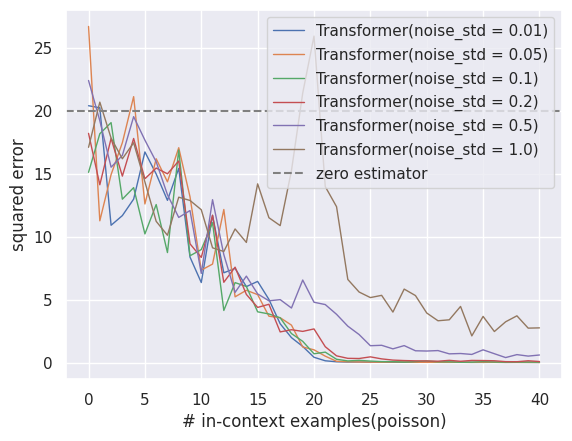

In [13]:
ys_result, pred_result, loss_result = get_inference_noise_std(noise_levels, task_sampler, xs, model)
visualize_inference_noise_std(baseline, noise_levels, loss_result, noise_name)

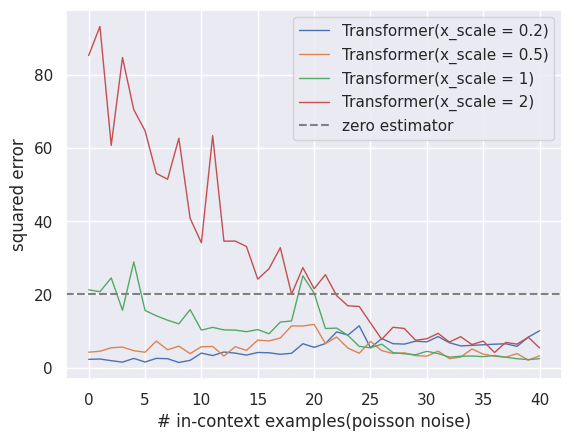

In [16]:
ys_result, pred_result, loss_result = get_inference_scale(noise_name, x_scales, task_sampler, xs, model)
visualize_inference_scale(baseline, x_scales, loss_result, noise_name)